# **The first Decision Tree: ID-3 from Scratch in Python**
*By Cristian Leo*

*Article Link*: https://medium.com/@cristianleo120/master-decision-trees-and-building-them-from-scratch-in-python-af173dafb836

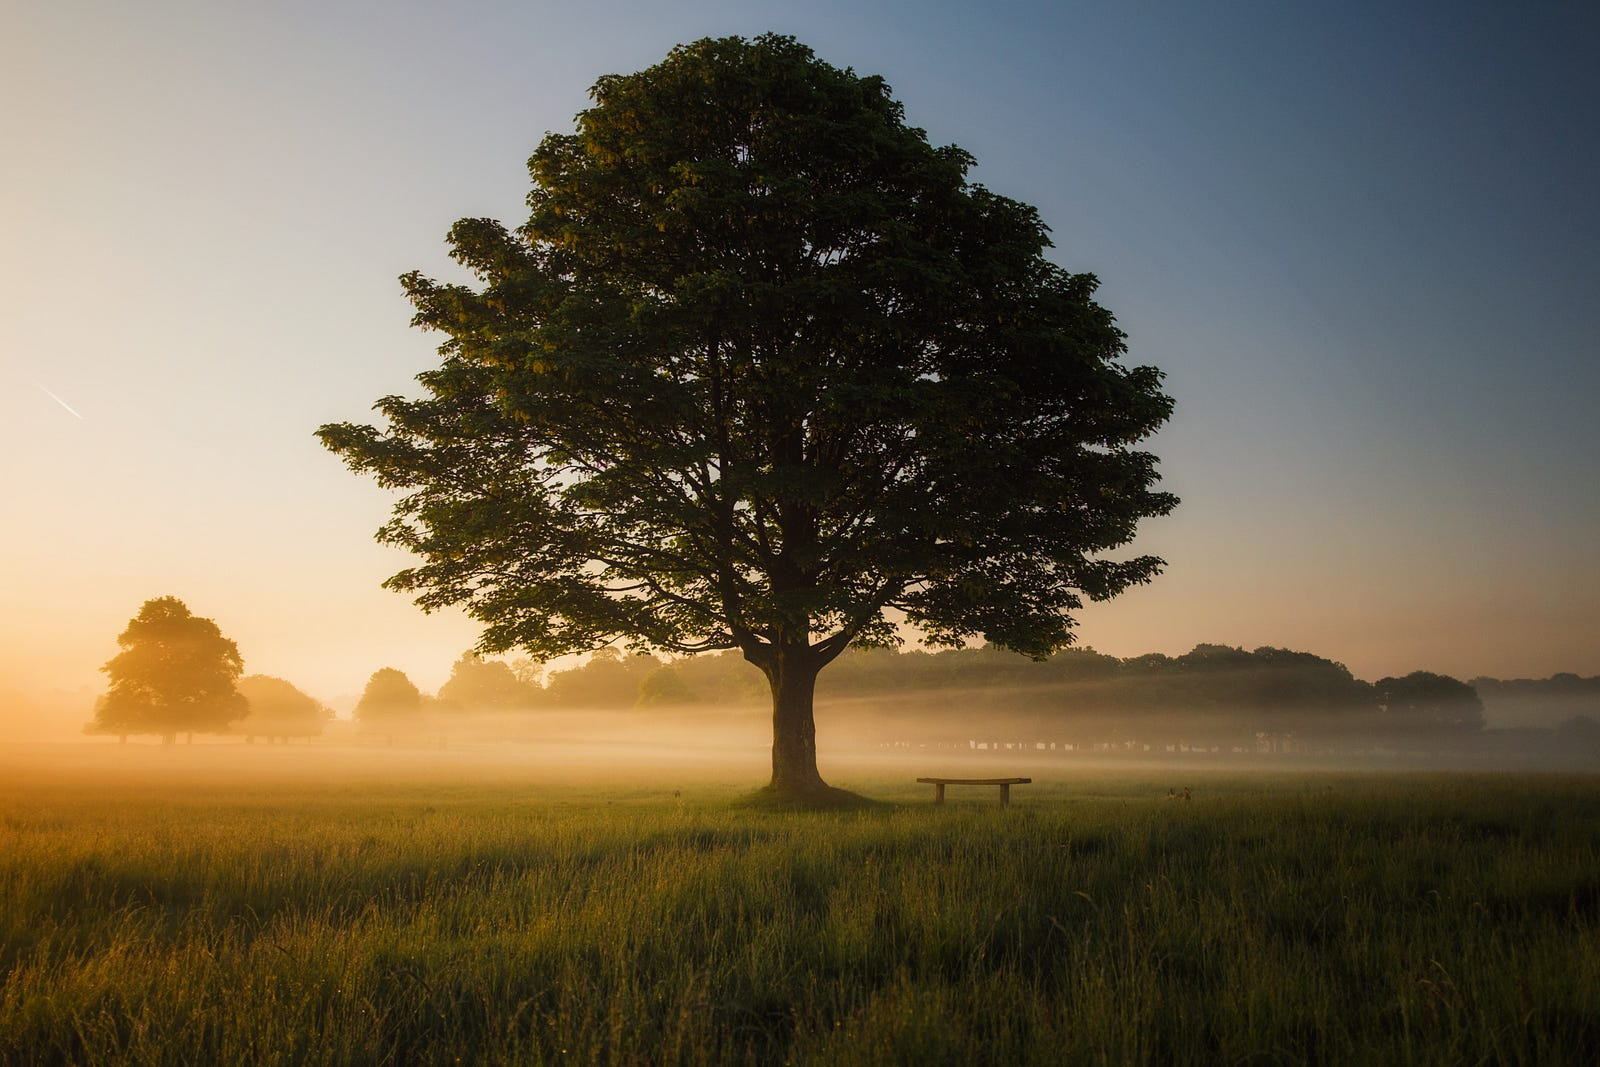

# Introduction

Decision trees represent a class of machine learning algorithms applicable to both classification and regression tasks. They operate by recursively partitioning data based on input features, providing interpretability and versatility. Decision trees are known for their ease of understanding, robustness to noise, and applicability to various datasets.

## How Decision Trees Work

Decision trees split data recursively to maximize the purity of subsets. The process continues until a stopping criterion, such as reaching a maximum depth, is met. Predictions are made by traversing the tree from the root to a leaf node based on feature values. The leaf node contains the predicted class label or regression value.

## Measuring Purity: Entropy and Gini Impurity

Purity of decision tree nodes is evaluated using entropy and Gini impurity. Entropy measures dataset uncertainty, while Gini impurity assesses the dataset's impurity. Both are effective, but Gini impurity is often preferred for its computational efficiency.

Entropy's formula is:

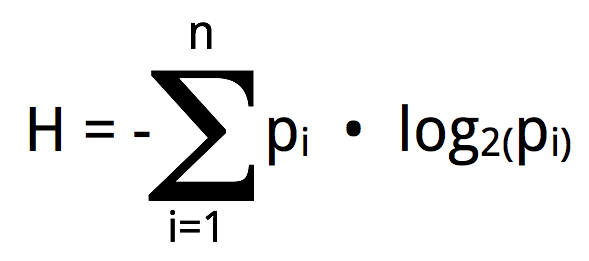

Gini Impurity's formula is:

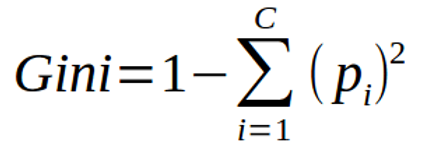

## Example

Consider a customer dataset predicting churn. Entropy and Gini impurity calculations indicate dataset impurity, highlighting the presence of customers likely to churn.

## Benefits of Decision Trees

- **Interpretability:** Easy to understand, making them suitable for applications where interpretability is crucial.
- **Robustness:** Relatively robust to noise and outliers, making them suitable for datasets with incomplete or noisy information.
- **Versatility:** Applicable to both classification and regression tasks, providing a versatile tool for various machine learning problems.

## Pitfalls of Decision Trees

- **Overfitting:** Prone to overfitting, necessitating pruning techniques and cross-validation to prevent memorizing training data.
- **Interpretability:** Growing trees can lead to complexity, hindering interpretability.

### Pitfall Examples

- **Overfitting Example:** Overfitted trees may fail to generalize to new data.
- **Interpretability Challenge:** As trees grow, interpreting complex splits becomes challenging.

Despite pitfalls, decision trees are powerful. Mitigating pitfalls ensures accurate and robust models.

## Avoiding Pitfalls

- **Pruning Techniques:** Reduce error pruning helps prevent overfitting.
- **Regularization:** Post-pruning aids in preventing overfitting.
- **Cross-validation:** Evaluate performance on unseen data using techniques like 5-fold cross-validation.
- **Robust Variants:** Choose robust decision tree variants less sensitive to outliers.
- **Size Control:** Maintain a small decision tree for better interpretability.

## Applications of Decision Trees

Decision trees find applications in:

- **Fraud Detection:** Identifying fraudulent transactions.
- **Medical Diagnosis:** Aiding in medical diagnostic processes.
- **Customer Segmentation:** Segmenting customers based on demographics and behavior.
- **Risk Assessment:** Assessing risks such as loan defaults or customer churn.

## Decision-Tree Based Algorithms

Several decision tree-based algorithms include:

- **ID3 (Iterative Dichotomiser 3):** A simple, effective algorithm maximizing information gain.
- **C4.5:** An ID3 extension handling missing values and continuous features.
- **CART (Classification And Regression Tree):** Suitable for both classification and regression tasks, minimizing Gini impurity.
- **Random Forest:** An ensemble algorithm using multiple decision trees.
- **Gradient Boosting Machines (GBMs):** Sequentially trains decision trees to correct errors.

These algorithms vary, and the choice depends on the specific dataset and task at hand. The decision tree landscape is rich and offers diverse solutions to cater to different needs.

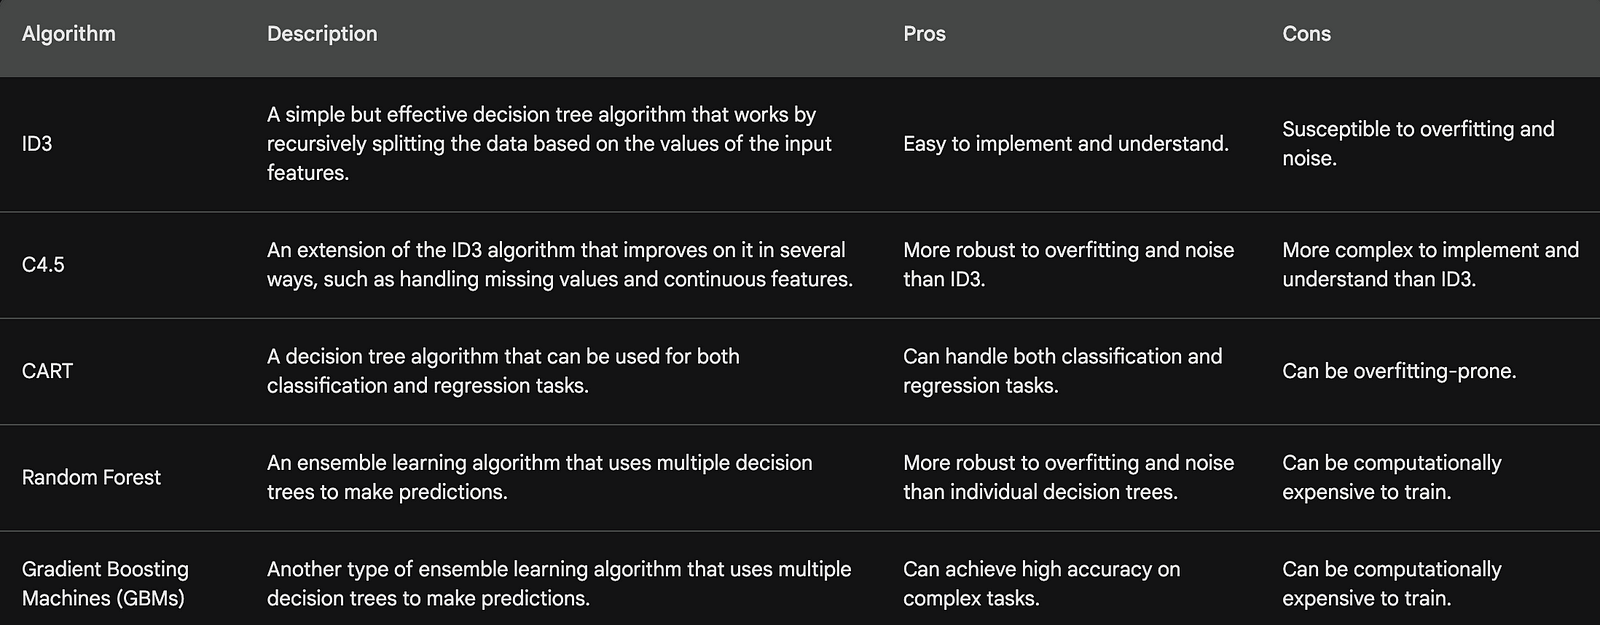

In [1]:
# Import Libraries
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class ID3Classifier:
    def __init__(self):
        self.tree = None

    class Node:
        def __init__(self, feature=None, threshold=None, value=None, left=None, right=None):
            self.feature = feature  # Index of feature to split on
            self.threshold = threshold  # Threshold value for the split
            self.value = value  # Predicted class (for leaf nodes)
            self.left = left  # Left child node
            self.right = right  # Right child node
            self.feature_importance = None

    def calculate_feature_importance(self, X, y):
        self.feature_importance = np.zeros(X.shape[1])
        self._calculate_feature_importance(self.tree, X, y)

    def _calculate_feature_importance(self, node, X, y, importance=1):
        if node.value is not None:
            return

        self.feature_importance[node.feature] += importance

        mask = X[:, node.feature] <= node.threshold
        self._calculate_feature_importance(node.left, X[mask], y[mask], importance * len(y[mask]) / len(y))
        self._calculate_feature_importance(node.right, X[~mask], y[~mask], importance * len(y[~mask]) / len(y))

    def entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))

    def information_gain(self, X, y, feature, threshold):
        mask = X[:, feature] <= threshold
        left_entropy = self.entropy(y[mask])
        right_entropy = self.entropy(y[~mask])
        parent_entropy = self.entropy(y)
        weight_left = sum(mask) / len(y)
        weight_right = sum(~mask) / len(y)
        return parent_entropy - (weight_left * left_entropy + weight_right * right_entropy)

    def find_best_split(self, X, y):
        num_features = X.shape[1]
        best_feature, best_threshold, max_gain = None, None, -1

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self.information_gain(X, y, feature, threshold)
                if gain > max_gain:
                    best_feature, best_threshold, max_gain = feature, threshold, gain

        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0, max_depth=None):
        if depth == max_depth or len(set(y)) == 1:
            return self.Node(value=np.argmax(np.bincount(y)))

        feature, threshold = self.find_best_split(X, y)
        if feature is None:
            return self.Node(value=np.argmax(np.bincount(y)))

        mask = X[:, feature] <= threshold
        left = self.build_tree(X[mask], y[mask], depth + 1, max_depth)
        right = self.build_tree(X[~mask], y[~mask], depth + 1, max_depth)

        return self.Node(feature=feature, threshold=threshold, left=left, right=right)

    def fit(self, X, y, max_depth=None):
        self.tree = self.build_tree(X, y, max_depth=max_depth)

    def predict_one(self, node, sample):
        if node.value is not None:
            return node.value
        if sample[node.feature] <= node.threshold:
            return self.predict_one(node.left, sample)
        else:
            return self.predict_one(node.right, sample)

    def predict(self, X):
        return [self.predict_one(self.tree, sample) for sample in X]

In [3]:
X, y = load_wine(return_X_y=True)

# Create a dataframe for the wine dataset
df = pd.DataFrame(X, columns=load_wine().feature_names)
df['target'] = y

# Display the dataframe
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


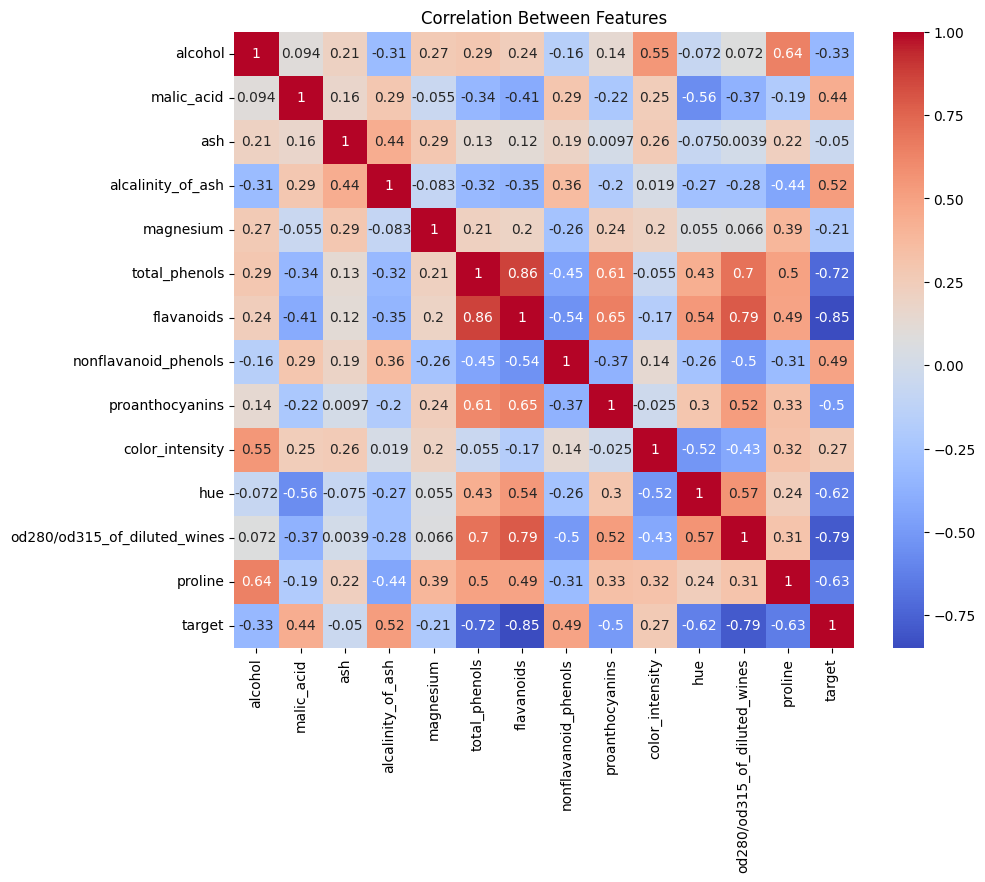

In [4]:
# Visualize the correlation between features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Features')
plt.show()

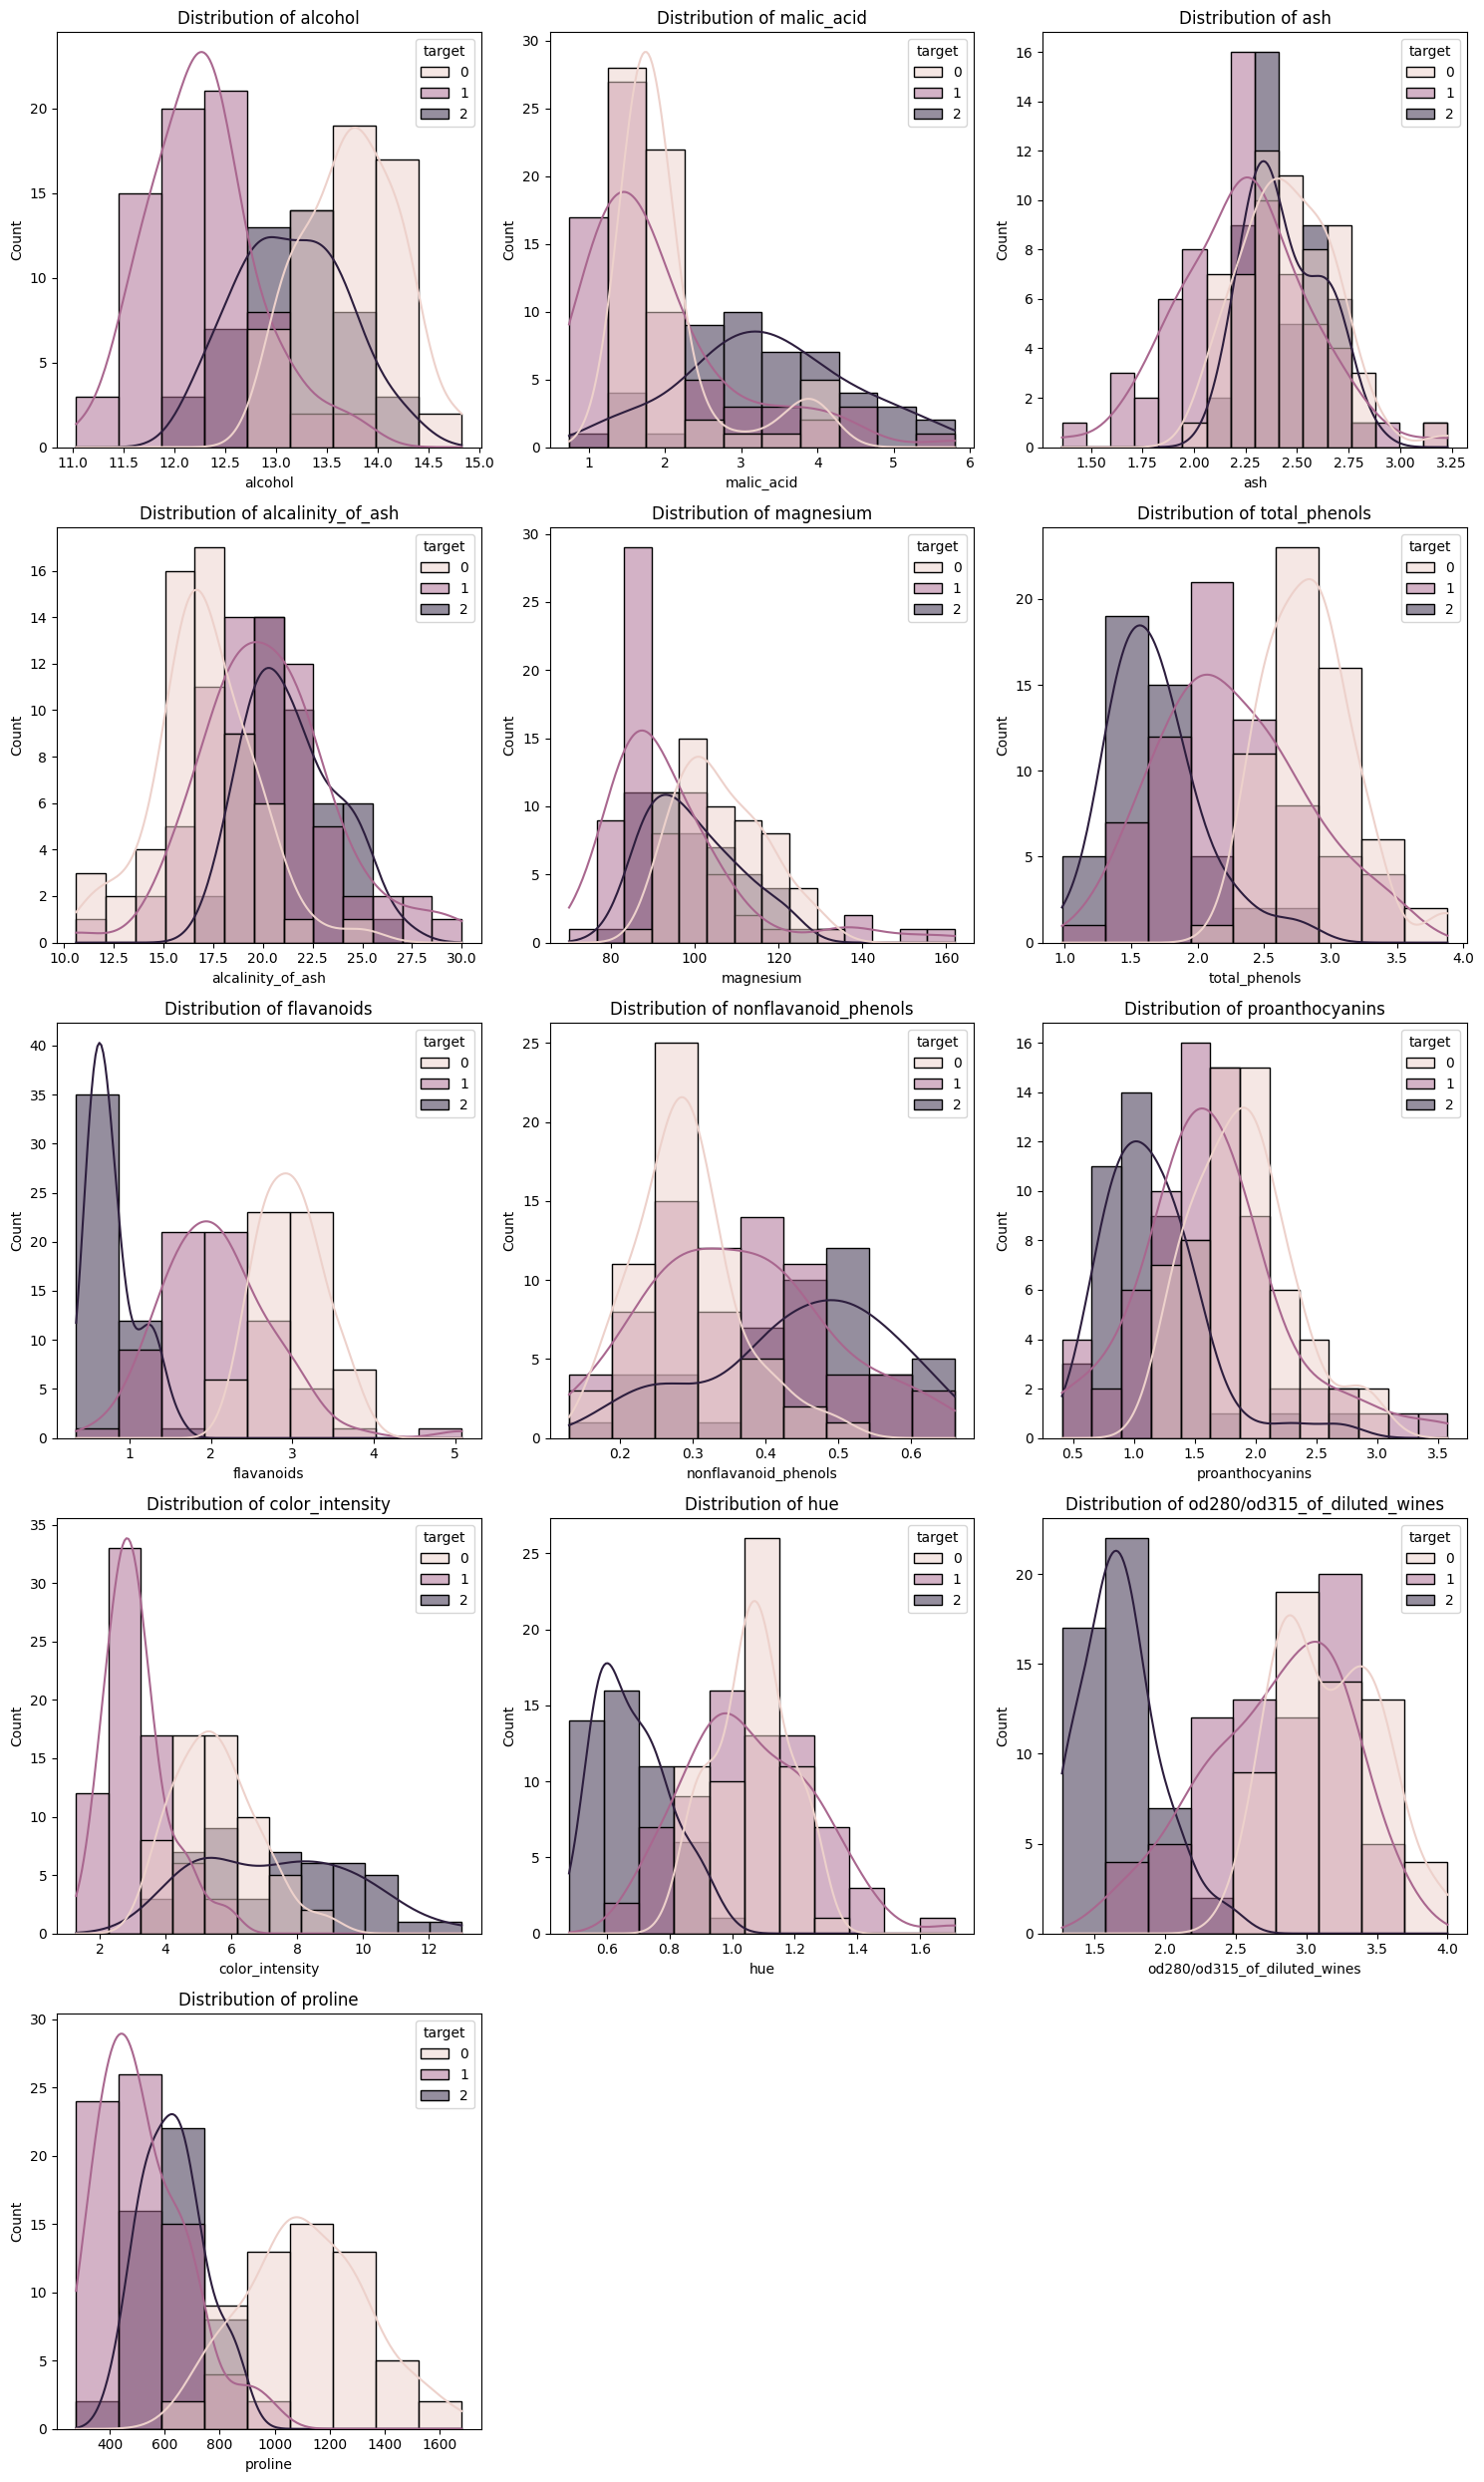

In [5]:
# Visualize the distribution of each feature
num_features = len(df.columns[:-1])
num_rows = num_features // 3 + (num_features % 3 > 0)

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, feature in enumerate(df.columns[:-1]):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.histplot(data=df, x=feature, hue='target', kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

# Remove empty subplots
if num_features % 3 != 0:
    for i in range(num_features % 3, 3):
        fig.delaxes(axes[num_rows-1, i])

plt.tight_layout()
plt.show()


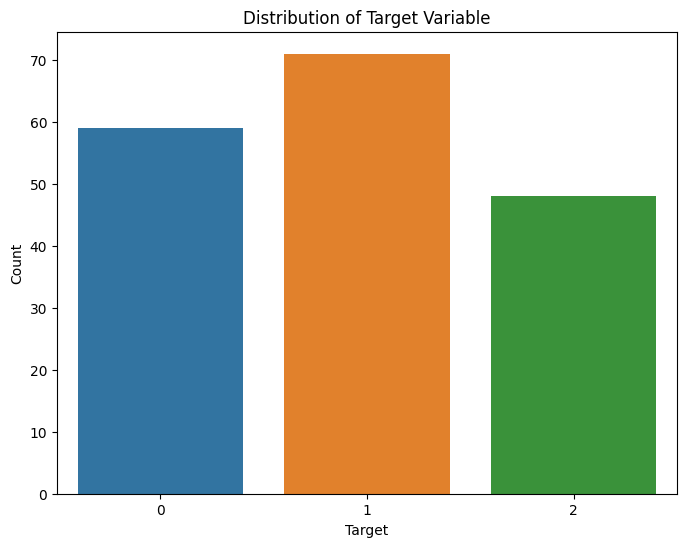

In [6]:
# Visualize the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [7]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

# Train Model
clf = ID3Classifier()
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {train_acc:.2%}')
print(f'Test Accuracy: {test_acc:.2%}')

Train Accuracy: 100.00%
Test Accuracy: 97.22%


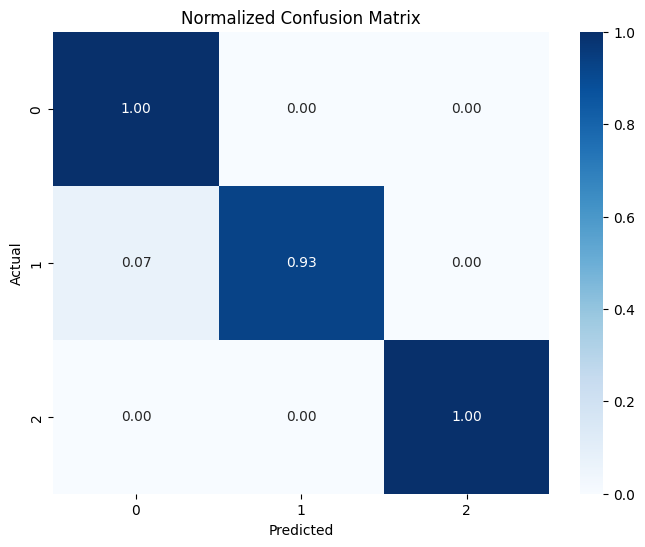

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')  # Use '.2f' format for normalized values
plt.title('Normalized Confusion Matrix')  # Update the title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

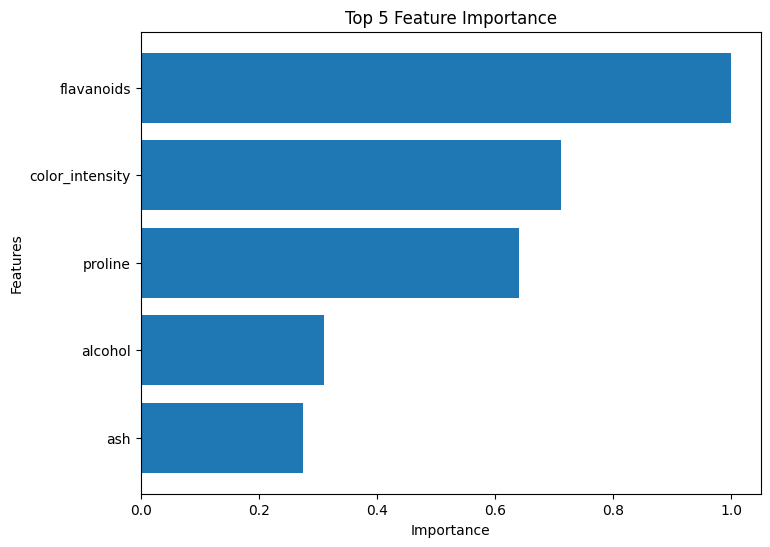

In [9]:
# Feature Importance
clf.calculate_feature_importance(X_train, y_train)
feature_importance = clf.feature_importance

# Sort features by descending importance
sorted_features = [feature for _, feature in sorted(zip(feature_importance, df.columns[:-1]), reverse=True)]
sorted_importance = sorted(feature_importance, reverse=True)

# Select the top 5 features
top_features = sorted_features[:5][::-1]
top_importance = sorted_importance[:5][::-1]

# Plot feature importance for the top 5 features
plt.figure(figsize=(8, 6))
plt.barh(top_features, top_importance)
plt.title('Top 5 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()